In [5]:
# EDA cơ bản: Giá & Missingness

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use('seaborn-v0_8')
sns.set_context('notebook')

DATA_DIR = Path('/Users/doananh/Documents/đồ án DS')
CLEAN_FILE = DATA_DIR / 'data_motobikes_clean.csv'
RAW_FILE = DATA_DIR / 'data_motobikes.xlsx - Sheet1.csv'

# Load cleaned if available else raw
if CLEAN_FILE.exists():
    df = pd.read_csv(CLEAN_FILE, low_memory=False)
    source = 'clean'
else:
    df = pd.read_csv(RAW_FILE, dtype=str, low_memory=False)
    source = 'raw'

print('Loaded source:', source)
print('Shape:', df.shape)
df.head(3)


Loaded source: clean
Shape: (7208, 30)


,id,tieu_de,gia_vnd_str,gia_min_tr_str,gia_max_tr_str,dia_chi,mo_ta,thuong_hieu,dong_xe,nam_dang_ky,...,gia_max_tr,gia_vnd_from_range,gia_vnd_final,dung_tich_cc,trong_luong_kg,phuong,quan,tinh_thanh,len_title,len_desc
0,1,"Bán Vespa Sprint 125cc 2024 xanh dương, xe đẹp...",66.000.000 đ,72.53 tr,85.14 tr,"Phường Bến Thành, Quận 1, Tp Hồ Chí Minh",Bán xe #Vespa Sprint 125cc. Mua mới tại #Topco...,Piaggio,Vespa,2024.0,...,85.14,78835000.0,66000000.0,137.5,50.0,Phường Bến Thành,Quận 1,Tp Hồ Chí Minh,50,181
1,2,🔥🔥SH 150i Thắng ABS 2019 BSTP Chính Chủ,79.500.000 đ,62.76 tr,73.68 tr,"Phường Tân Định, Quận 1, Tp Hồ Chí Minh","_Bán SH 150i Thắng ABS 2019 Xám Bạc, Úp Team X...",Honda,SH,2019.0,...,73.68,68220000.0,79500000.0,137.5,50.0,Phường Tân Định,Quận 1,Tp Hồ Chí Minh,39,284
2,3,CC Vision Thể Thao 2023 Đen+bộ đèn Demi audi A7,37.000.000 đ,28 tr,32.86 tr,"Phường Cầu Kho, Quận 1, Tp Hồ Chí Minh",Chính chủ bán Vision phiên bản Thể Thao 2023 Đ...,Honda,Vision,2023.0,...,32.86,30430000.0,37000000.0,137.5,50.0,Phường Cầu Kho,Quận 1,Tp Hồ Chí Minh,47,278


In [6]:
# Xác định cột giá và fallback khi chưa clean

def coalesce_price(df: pd.DataFrame) -> pd.Series:
    if 'gia_vnd_final' in df.columns:
        return df['gia_vnd_final']
    # Fallback tối giản: trích số từ cột 'Giá'
    import re
    def parse_price(v):
        if pd.isna(v):
            return np.nan
        m = re.search(r"\d[\d\.]*", str(v))
        if not m:
            return np.nan
        return float(m.group(0).replace('.', ''))
    if 'Giá' in df.columns:
        return df['Giá'].apply(parse_price)
    return pd.Series(np.nan, index=df.index)

price_vnd = coalesce_price(df)
print('Giá có sẵn:', price_vnd.notna().sum(), 'rows')


Giá có sẵn: 7206 rows


In [7]:
# Thống kê Giá và tỷ lệ thiếu

# Thống kê cơ bản cho Giá (VND)
price_stats = price_vnd.describe(percentiles=[0.05,0.1,0.25,0.5,0.75,0.9,0.95]).to_frame('gia_vnd').round(2)
print(price_stats)

# Tỷ lệ thiếu theo cột
missing_pct = df.isna().mean().sort_values(ascending=False).to_frame('missing_rate')
print(missing_pct.head(20))

# Lưu CSV để dùng trong báo cáo
price_stats.to_csv(DATA_DIR / 'eda_price_stats.csv')
missing_pct.to_csv(DATA_DIR / 'eda_missingness.csv')
print('Saved eda_price_stats.csv & eda_missingness.csv')


            gia_vnd
count  7.206000e+03
mean   4.924194e+07
std    1.603077e+09
min    0.000000e+00
5%     3.200000e+06
10%    4.500000e+06
25%    8.500000e+06
50%    1.650000e+07
75%    3.250000e+07
90%    6.500000e+07
95%    9.387500e+07
max    1.360000e+11
                    missing_rate
xuat_xu                 0.160239
so_km                   0.044534
gia_vnd_from_range      0.028024
gia_min_tr_str          0.028024
gia_min_tr              0.028024
gia_max_tr_str          0.027331
gia_max_tr              0.027331
nam_dang_ky             0.009295
dung_tich_cc            0.009156
tinh_thanh              0.005966
phuong                  0.005688
quan                    0.005688
dia_chi                 0.005688
dung_tich               0.001110
dong_xe                 0.000416
thuong_hieu             0.000416
gia_vnd                 0.000277
gia_vnd_str             0.000277
gia_vnd_final           0.000277
trong_luong_kg          0.000139
Saved eda_price_stats.csv & eda_missingness.csv

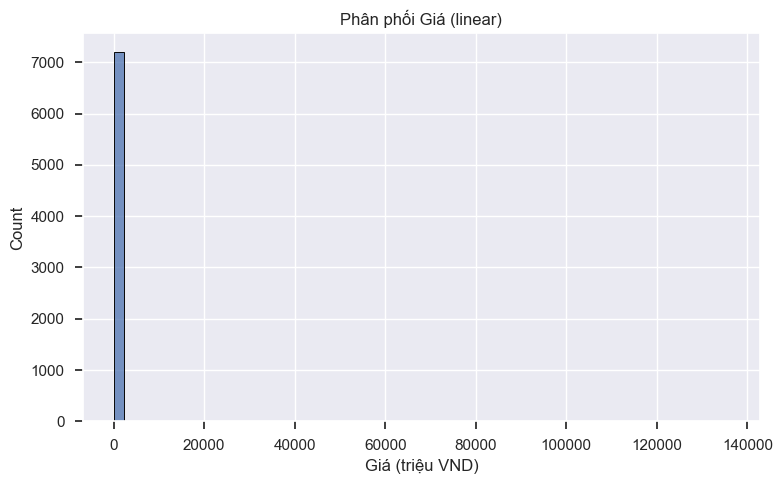

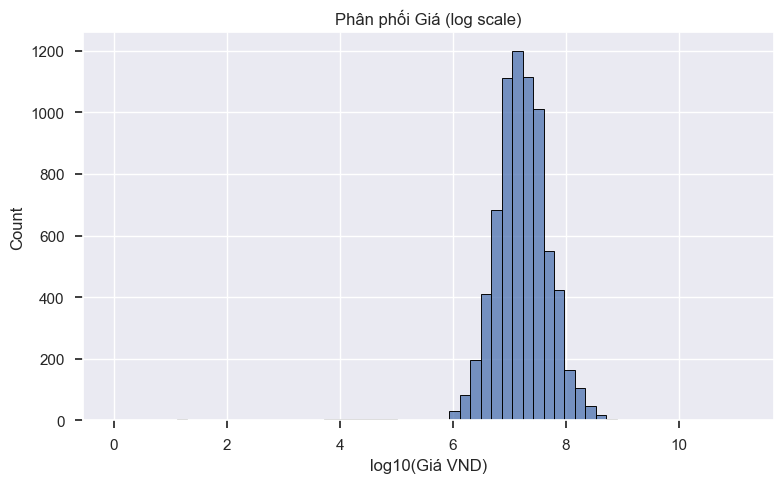

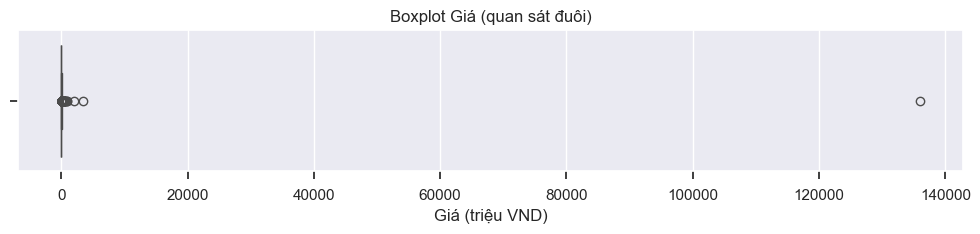

Saved plots: /Users/doananh/Documents/đồ án DS/eda_price_hist_linear.png /Users/doananh/Documents/đồ án DS/eda_price_hist_log.png /Users/doananh/Documents/đồ án DS/eda_price_box.png


In [9]:
# Phân phối Giá: histogram + boxplot (linear & log)

PLOT_DIR = DATA_DIR

# Histogram (triệu VND)
plt.figure(figsize=(8,5))
sns.histplot((price_vnd/1_000_000).dropna(), bins=60)
plt.xlabel('Giá (triệu VND)')
plt.title('Phân phối Giá (linear)')
plt.tight_layout()
linear_hist_path = PLOT_DIR / 'eda_price_hist_linear.png'
plt.savefig(linear_hist_path, dpi=150)
plt.show()

# Histogram (log-scale VND)
plt.figure(figsize=(8,5))
valid = price_vnd[price_vnd>0]
sns.histplot(np.log10(valid), bins=60)
plt.xlabel('log10(Giá VND)')
plt.title('Phân phối Giá (log scale)')
plt.tight_layout()
log_hist_path = PLOT_DIR / 'eda_price_hist_log.png'
plt.savefig(log_hist_path, dpi=150)
plt.show()

# Boxplot (triệu VND)
plt.figure(figsize=(10,2.5))
sns.boxplot(x=(price_vnd/1_000_000))
plt.xlabel('Giá (triệu VND)')
plt.title('Boxplot Giá (quan sát đuôi)')
plt.tight_layout()
box_path = PLOT_DIR / 'eda_price_box.png'
plt.savefig(box_path, dpi=150)
plt.show()

print('Saved plots:', linear_hist_path, log_hist_path, box_path)
